# Final Project
## Cohort 1 Group 7

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

### Data process

In [2]:
# initial setting
symbol_dict = {
    'sp6m': '^GSPC','sp12m': '^GSPC','bac': 'BAC','citi': 'C','iyr': 'IYR',
    'corn': 'ZC=F','soybns': 'ZS=F','wheat': 'ZW=F','silver': 'SI=F',
    'euro': 'EURUSD=X','gold': 'GC=F','yen': 'JPYUSD=X','pound': 'GBPUSD=X','tr10yr': '^IRX','tr5yr': '^IRX',
}

startdate = '2015-01-01'
enddate = '2023-12-31'

In [3]:
# get underlying asset price
for ticker, symbol in symbol_dict.items():
    stock_data = yf.download(symbol, start=startdate, end=enddate, progress=False)
    
    close_data = stock_data['Close'].reset_index()
    close_data.rename(columns={'Close': ticker}, inplace=True)
    if ticker == 'sp6m':
        price_df = close_data
    else:
        price_df = pd.merge(price_df, close_data, on='Date', how='outer')
price_df.sort_values(by='Date',inplace=True)
price_df.ffill(inplace=True)

In [4]:
# get mpd data
mpd_df = pd.read_csv('mpd_stats.csv',skiprows=3)
mpd_df['idt'] = pd.to_datetime(mpd_df['idt'], format='%m/%d/%Y')
mpd_df = mpd_df[(mpd_df.idt>=startdate)&(mpd_df.idt<=enddate)]
mpd_df = mpd_df[mpd_df.market.isin(symbol_dict)]
mpd_df.rename(columns={'idt': 'Date'}, inplace=True)
mpd_df['Date'] = np.where(mpd_df['Date']=='2017-06-21',pd.to_datetime('2017-06-22'),mpd_df['Date'])
mpd_df['Date'] = pd.to_datetime(mpd_df['Date'])
mpd_df.reset_index(inplace=True,drop=True)

In [5]:
# calculate underlying asset log-return
mat_df = mpd_df[['market','maturity_target']].drop_duplicates().dropna().reset_index(drop=True)
mat_dict = mat_df.set_index('market')['maturity_target'].to_dict()
mu_df = mpd_df.pivot(index='Date', columns=['market'], values='mu')
tradedate = mu_df.index.values
price_df_week = price_df[price_df.Date.isin(tradedate)]
price_df_week.set_index('Date', inplace=True, drop=True)

ret_df = pd.DataFrame(columns=list(symbol_dict.keys()))
for s in symbol_dict.keys():
    maturity = mat_dict[s]
    weeks = int(13*(maturity//3))
    ret = np.log(1+price_df_week[s].pct_change(weeks))
    ret_df[s]=ret
ret_df.set_index(tradedate,inplace=True)

In [6]:
# calculate the probability
def probability_in_range(mean, std_dev, skewness, kurtosis, number):
    # Calculate the parameters of the Johnson SU distribution from mean, std_dev, skewness, and kurtosis
    a, b, loc, scale = stats.johnsonsu.fit(data=(mean, std_dev, skewness, kurtosis))

    # Calculate the probability using the cumulative distribution function (CDF)
    prob = stats.johnsonsu.cdf(number, a, b, loc, scale)

    return prob

prob_df = pd.DataFrame(columns=list(symbol_dict.keys()))
for s in symbol_dict.keys():
    maturity = mat_dict[s]
    weeks = int(13*(maturity//3))
    data = mpd_df[mpd_df['market']==s]
    prob_df[s] = probability_in_range(data['mu'], data['sd'], data['skew'], data['kurt'], ret_df[s].shift(-weeks))
prob_df.set_index(tradedate,inplace=True)

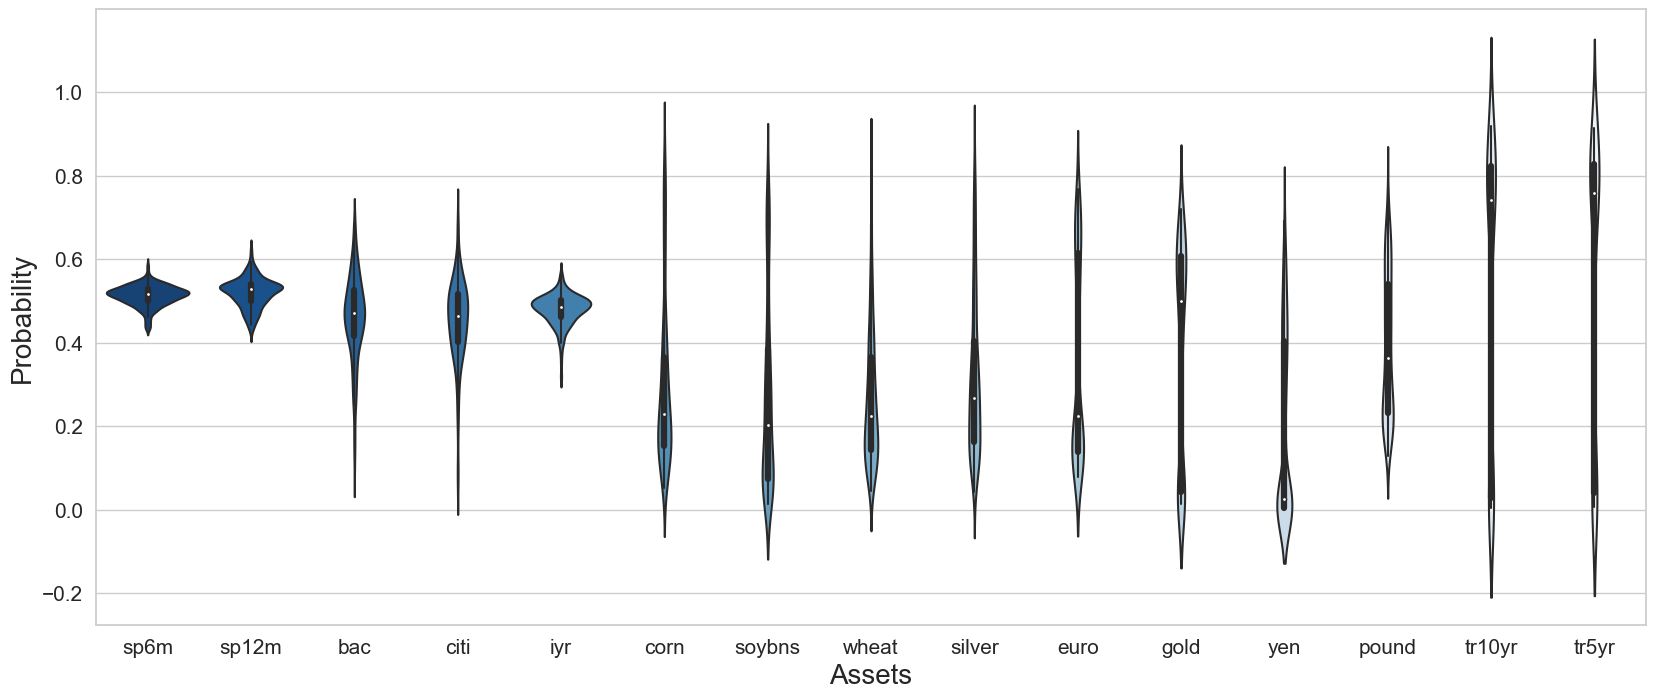

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,8))
sns.violinplot(prob_df,palette='Blues_r')
plt.xlabel('Assets', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

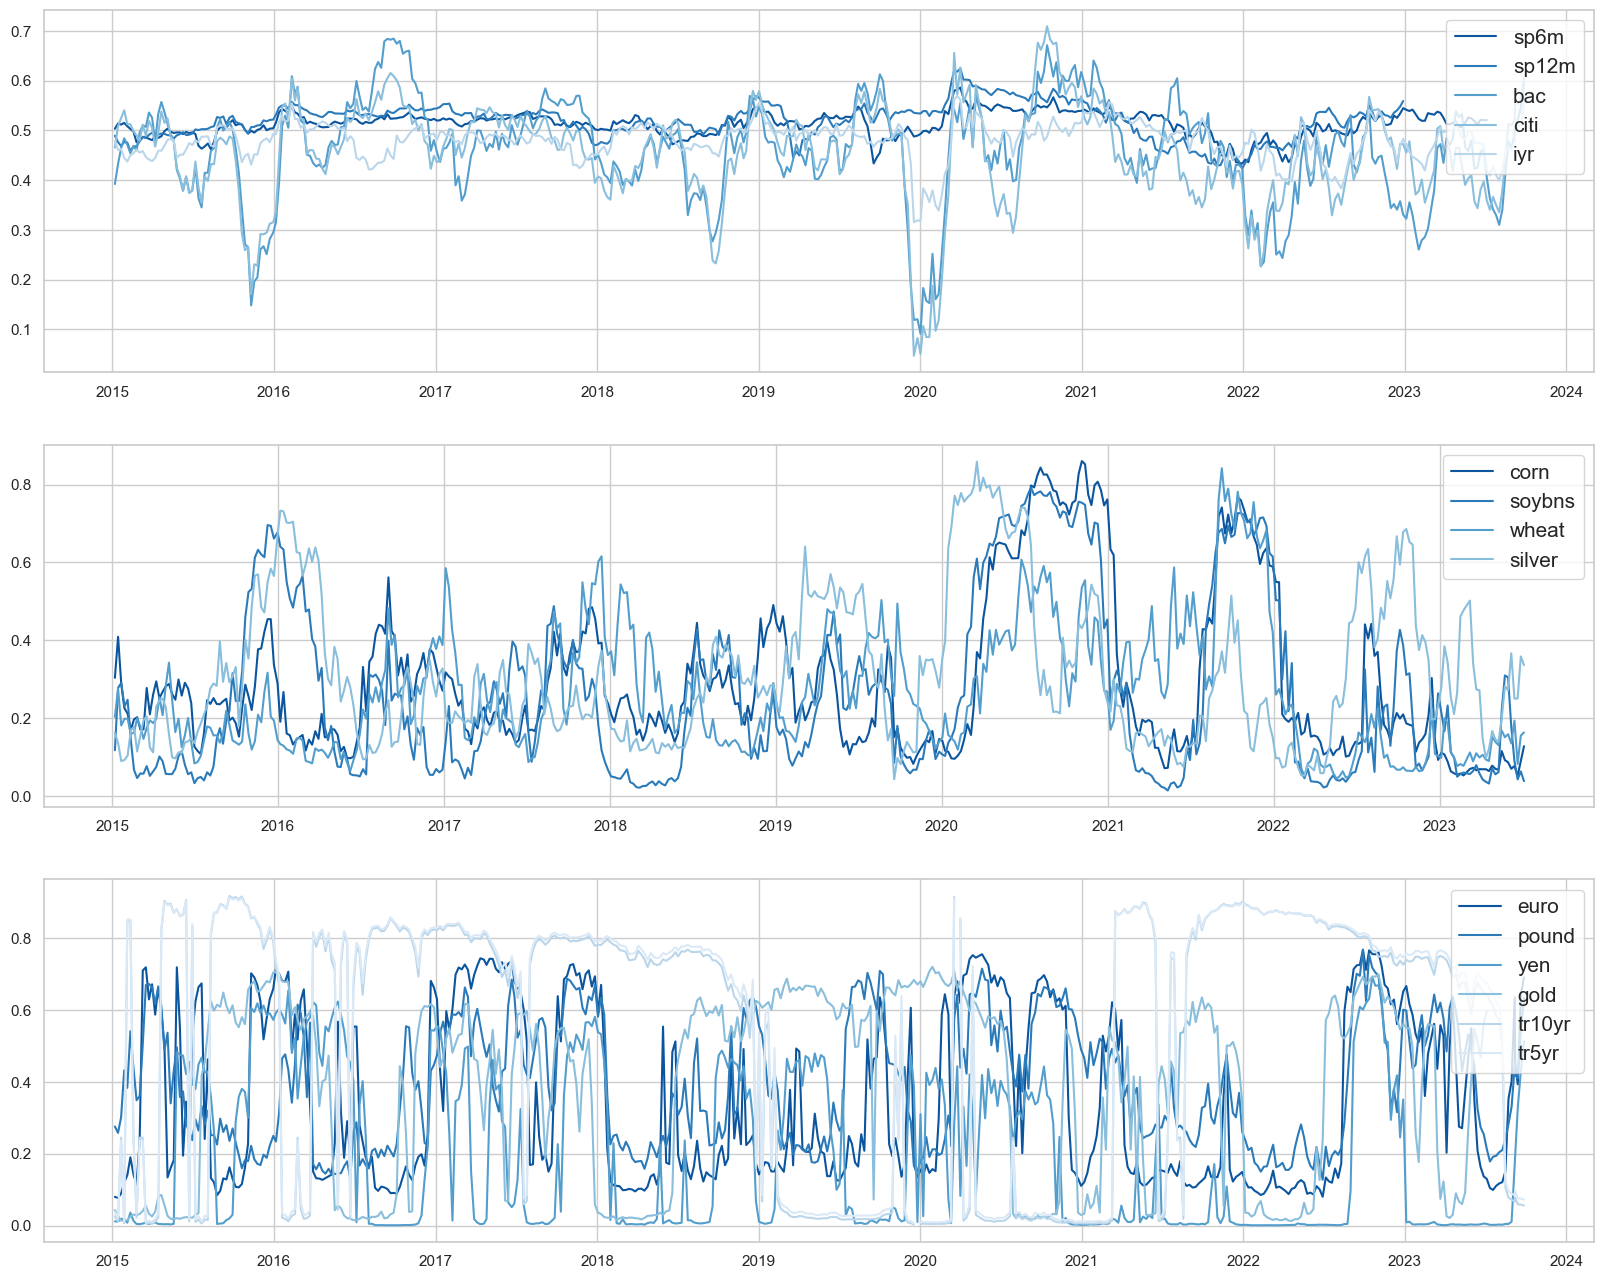

In [8]:
equity = ['sp6m','sp12m','bac','citi','iyr']
commodity = ['corn','soybns','wheat','silver']
fx = ['euro','pound','yen','gold','tr10yr','tr5yr']
sns.set_palette("Blues_r")

plt.figure(figsize=(20, 16))

plt.subplot(3, 1, 1)
for e in equity:
    plt.plot(prob_df.index,prob_df[e],label=e)
plt.legend(loc='upper right',fontsize=15)

plt.subplot(3, 1, 2)
for c in commodity:
    plt.plot(prob_df.index,prob_df[c],label=c)
plt.legend(loc='upper right',fontsize=15)

plt.subplot(3, 1, 3)
for f in fx:
    plt.plot(prob_df.index,prob_df[f],label=f)
plt.legend(loc='upper right',fontsize=15)

plt.show()

### Heston Model SDE
The heston model is defined by a system of SDEs, to describe the movement of asset prices, where an
asset’s price and volatility follow random, Brownian motion processes (this is under real world measure $\mathbb{P}$):

$$\large dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$$
    
$$\large dv_t = \kappa(\theta - v_t)dt +\sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$$

Where the variables are:
- $\sigma$ volatility of volatility
- $\theta$ long-term price variance
- $\kappa$ rate of reversion to the long-term price variance
- $dW^\mathbb{P}_{S,t}$ Brownian motion of asset price
- $dW^\mathbb{P}_{v,t}$ Brownian motion of asset's price variance
- $\rho^\mathbb{P}$ correlation between $dW^\mathbb{P}_{S,t}$ and $dW^\mathbb{P}_{v,t}$



Obviously as discussed one of the nice things about the Heston model for European option prices is that there is a closed-form solution once you have the characteristic function. So discretisation of the SDE is not required for valuing a European option, however if you would like to value other option types with complex features using the Heston model than you can use the following code:

#### Euler Discretisation of SDEs
$$\Large dS_{i+1} = S_i e^{(r-\frac{v_i}{2}) \Delta t + \sqrt{v_{i}}\Delta tW^\mathbb{P}_{S,i+1}}$$
    
$$\large v_{i+1} = v_i + \kappa(\theta - v_t)\Delta t +\sigma \sqrt{v_i} \Delta t W^\mathbb{P}_{v,i+1}$$

In [9]:
def log_likelihood(x,ret):
    mu, theta, sigma, v0, kappa, rho = [param for param in x]
    residual = ret-mu
    realized = residual**2
    expected = np.zeros(ret.shape)
    expected[0] = v0
    for i in range(1,len(expected)):
        expected[i] = residual[i-1]+kappa*(theta - residual[i-1])
    log_likelihood = np.log(1/(2*np.pi*np.sqrt(expected)*sigma*np.sqrt(1-rho**2))*
                       np.exp(-((residual/expected)**2-2*rho*(residual/expected)*(realized-expected)/sigma+((realized-expected)/sigma)**2)
                       /(2*(1-rho**2))))
    return -np.sum(log_likelihood)

In [10]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma, mu0, T, N, M):
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (mu0 - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)

    return S, v

In [11]:
def get_heston(ret_arr,S0):

    # Initialization
    residual_arr = ret_arr-np.mean(ret_arr)
    realized_arr = residual_arr**2
    mu0 = np.mean(ret_arr)
    theta0 = np.var(residual_arr)
    sigma0 = np.std(realized_arr)
    kappa0 = 1
    rho0 = 0
    v00 = abs(mu0)

    params = {"mu": {"x0": mu0, "lbub": [-3,3]},
          "theta": {"x0": theta0, "lbub": [1e-3,3]},
          "sigma": {"x0": sigma0, "lbub": [1e-2,3]},
          "v0": {"x0": v00, "lbub": [1e-3,3]},
          "kappa": {"x0": kappa0, "lbub": [1e-3,5]},
          "rho": {"x0": rho0, "lbub": [-0.99,0.999]}
          }

    x0 = [param["x0"] for key, param in params.items()]
    bnds = [param["lbub"] for key, param in params.items()]
    result = minimize(log_likelihood, x0 , args=(ret_arr), tol=1e-3, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)

    # simulation dependent
    T = 1/50               # time in years
    N = 63                # number of time steps in simulation
    M = 2000               # number of simulations

    # Heston dependent parameters
    mu, theta, sigma, v0, kappa, rho = result.x
    #print(result.x)
    S_p,v_p = heston_model_sim(S0, v0, rho, kappa, theta, sigma, mu, T, N, M)
    logret = np.log(S_p[N]/S0)
    hes_mu = np.mean(logret)
    hes_sd = np.std(logret)
    hes_skew = stats.skew(logret)
    hes_kurt = stats.kurtosis(logret)
    hes_p10,hes_p50,hes_p90 = np.percentile(logret, [10, 50, 90])

    return hes_mu,hes_sd,hes_skew,hes_kurt,hes_p10,hes_p50,hes_p90


In [12]:
ticker = 'yen'
symbol = 'JPYUSD=X'

startdate2 = '2012-12-31'
np.random.seed(123)

# get price data
stock_data = yf.download(symbol, start=startdate2, end=enddate, progress=False)
df = stock_data['Close'].reset_index()
df['ret'] = np.log(1+df['Close'].pct_change())*100
df.dropna(inplace=True)

#generate hestion process
cols = ['mu','sd','skew','kurt','p10','p50','p90']
hes_df = pd.DataFrame(index=tradedate,columns=cols)

# pre week
for date in tradedate:
    begin = date - pd.Timedelta(days=504)
    end = date - pd.Timedelta(days=1)
    data = df[(df.Date>=begin)&(df.Date<=end)]
    ret_arr = np.array(data['ret'])
    S0 = data['Close'].iloc[-1]
    hes_df.loc[date] = get_heston(ret_arr,S0)

hes_df.reset_index(drop=False,inplace=True)
hes_df.rename(columns={'index': 'Date'}, inplace=True)

### Compare Q measure and P measure

In [13]:
q_df =  mpd_df[mpd_df.market=='yen']
q_df = q_df[['Date']+cols]
q_df.reset_index(inplace=True,drop=True)
q_df = q_df.rename(columns={col: col + '_q' for col in cols})
hes_df = hes_df.rename(columns={col: col + '_p' for col in cols})

pq_df = pd.merge(q_df,hes_df,on='Date')
pq_df.set_index('Date',inplace=True)

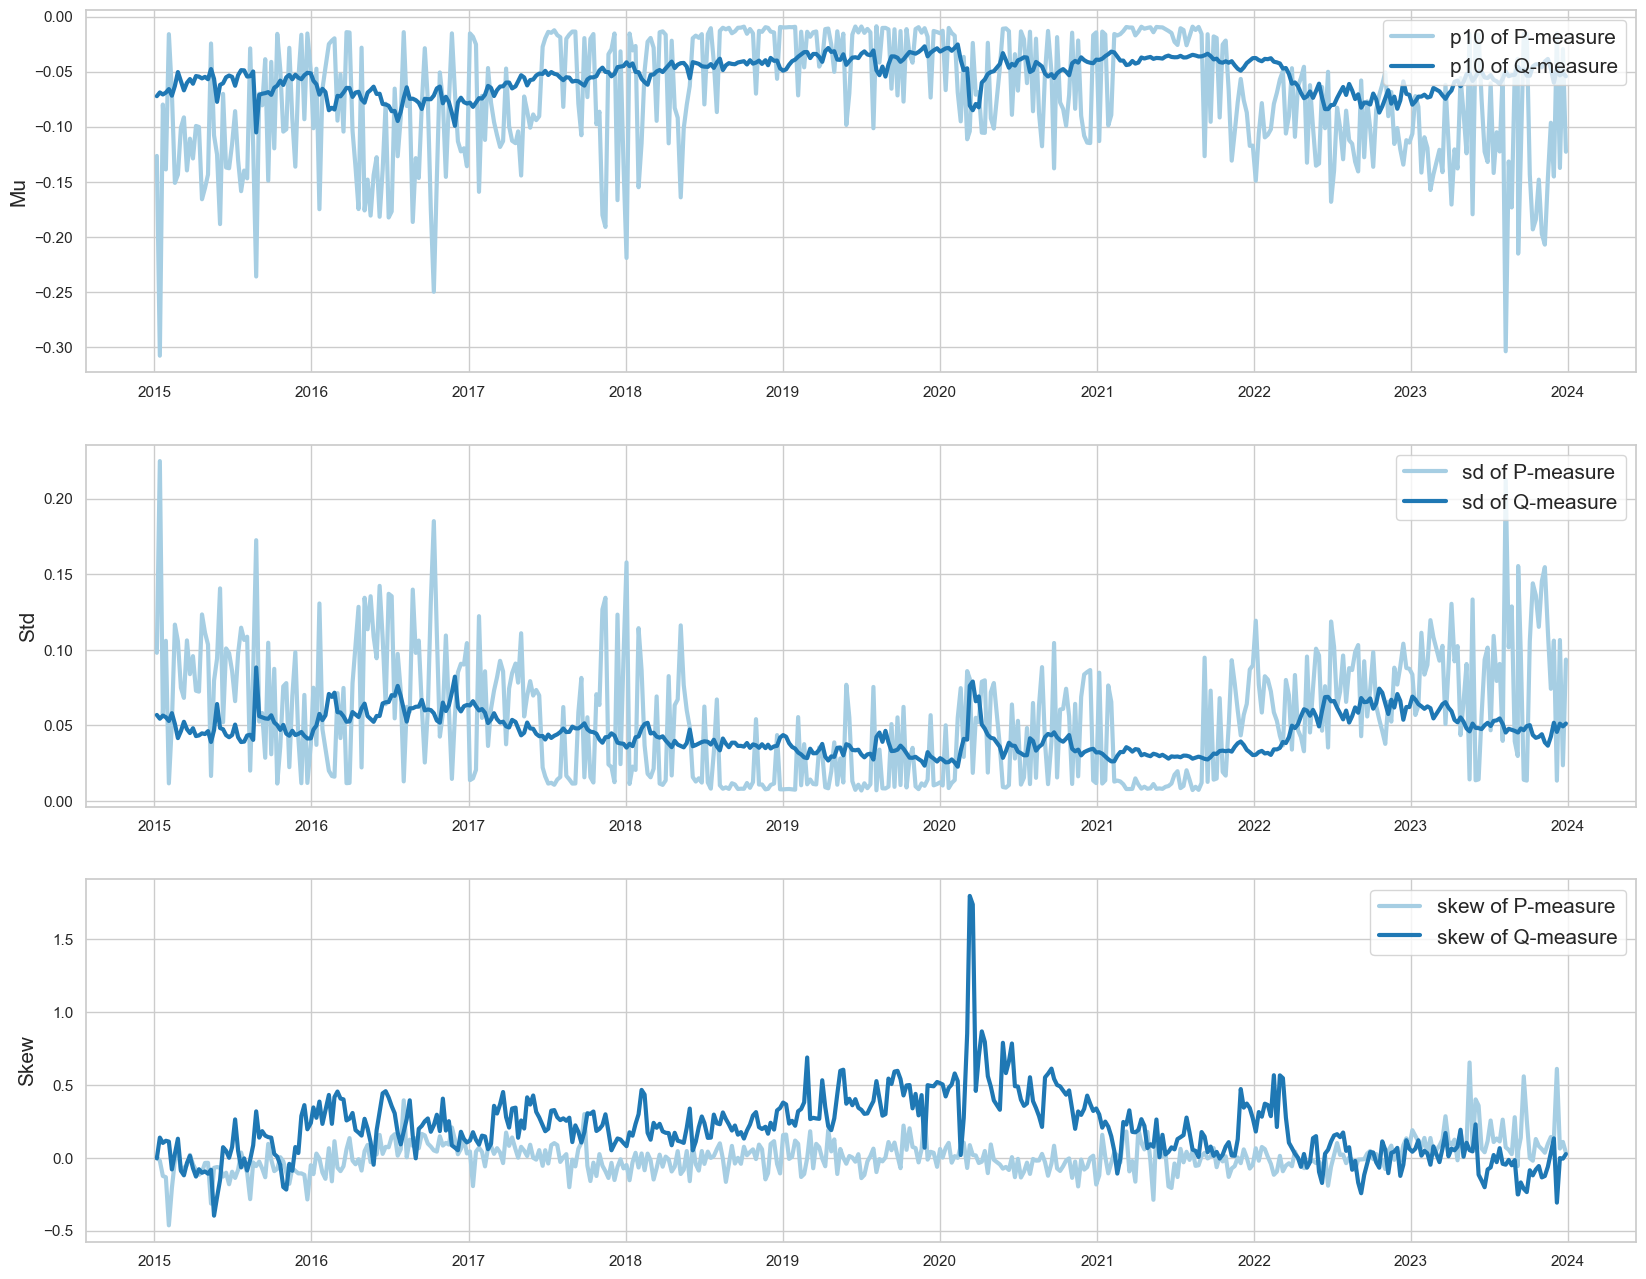

In [14]:
sns.set(style='whitegrid',palette='Paired')
plt.figure(figsize=(20,16))
plt.subplot(3,1,1)
plt.plot(pq_df.index,pq_df['p10_p'],label='p10 of P-measure',linewidth=3)
plt.plot(pq_df.index,pq_df['p10_q'],label='p10 of Q-measure',linewidth=3)
plt.ylabel('Mu',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.subplot(3,1,2)
plt.plot(pq_df.index,pq_df['sd_p'],label='sd of P-measure',linewidth=3)
plt.plot(pq_df.index,pq_df['sd_q'],label='sd of Q-measure',linewidth=3)
plt.ylabel('Std',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.subplot(3,1,3)
plt.plot(pq_df.index,pq_df['skew_p'],label='skew of P-measure',linewidth=3)
plt.plot(pq_df.index,pq_df['skew_q'],label='skew of Q-measure',linewidth=3)
plt.ylabel('Skew',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.show()

### Create signal and strategy

In [15]:
pq_df['signal_1'] = np.where(pq_df['mu_p']-pq_df['mu_p'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_2'] = np.where(pq_df['mu_q']-pq_df['mu_q'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_3'] = np.where(pq_df['sd_p']-pq_df['sd_p'].rolling(4).mean() < 0, 1, -1)
pq_df['signal_4'] = np.where(pq_df['sd_q']-pq_df['sd_q'].rolling(4).mean() < 0, 1, -1)
pq_df['signal_5'] = np.where(pq_df['skew_p']-pq_df['skew_p'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_6'] = np.where(pq_df['skew_q']-pq_df['skew_q'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_7'] = np.where(pq_df['kurt_p']-pq_df['kurt_p'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_8'] = np.where(pq_df['kurt_q']-pq_df['kurt_q'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_9'] = np.where(pq_df['p10_p']-pq_df['p10_p'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_10'] = np.where(pq_df['p10_q']-pq_df['p10_q'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_11'] = np.where(pq_df['p90_p']-pq_df['p90_p'].rolling(4).mean() > 0, 1, -1)
pq_df['signal_12'] = np.where(pq_df['p90_q']-pq_df['p90_q'].rolling(4).mean() > 0, 1, -1)

In [16]:
signal_columns = [ f'signal_{i}' for i in range(1,13)]
pq_df['strategy'] = np.where(pq_df[signal_columns].sum(axis=1) >= 0,1,-1)

In [17]:
stock_data = yf.download(symbol, start=startdate, end=enddate, progress=False)
bench_df = stock_data['Close'].reset_index()
bench_df.set_index('Date',inplace=True)
bench_df['Return'] = bench_df['Close'].pct_change().fillna(0)
bench_df = bench_df[bench_df.index>='2016-01-01']
bench_df['NAV'] = (1+bench_df['Return']).cumprod()

In [18]:
def MaxDrawdown(return_list):
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])

    return (return_list[j] - return_list[i]) / (return_list[j])

name = 'strategy'

data = pd.concat([bench_df,pq_df[name].shift(1)],axis=1)
data = data[data.index>='2016-01-01']
data = data.fillna(method='bfill')
data = data.fillna(0)
data['return'] = data['Return']*data[name]
data['nav'] = (1+data['return']).cumprod()

col = ['Return','Excess_Return','Volatility','Sharpe_Ratio','MaxDrowdown','NAV']
result = pd.DataFrame(index=[name],columns=col)
result.loc[name,'Return'] = np.log(data['return']+1).mean()*252*100
result.loc[name,'Excess_Return'] = np.log(data['return']-data['Return']+1).mean()*252*100
result.loc[name,'Volatility'] = np.std(data['return'])*np.sqrt(252)
result.loc[name,'Sharpe_Ratio'] = np.mean(data['return']-data['Return'])/np.std(data['return'])*np.sqrt(252)
result.loc[name,'MaxDrowdown'] = MaxDrawdown(data['nav'])
result.loc[name,'NAV'] = data['nav'][-1]

result

,Return,Excess_Return,Volatility,Sharpe_Ratio,MaxDrowdown,NAV
strategy,6.676328,8.055886,0.08823,0.978583,0.125222,1.736934


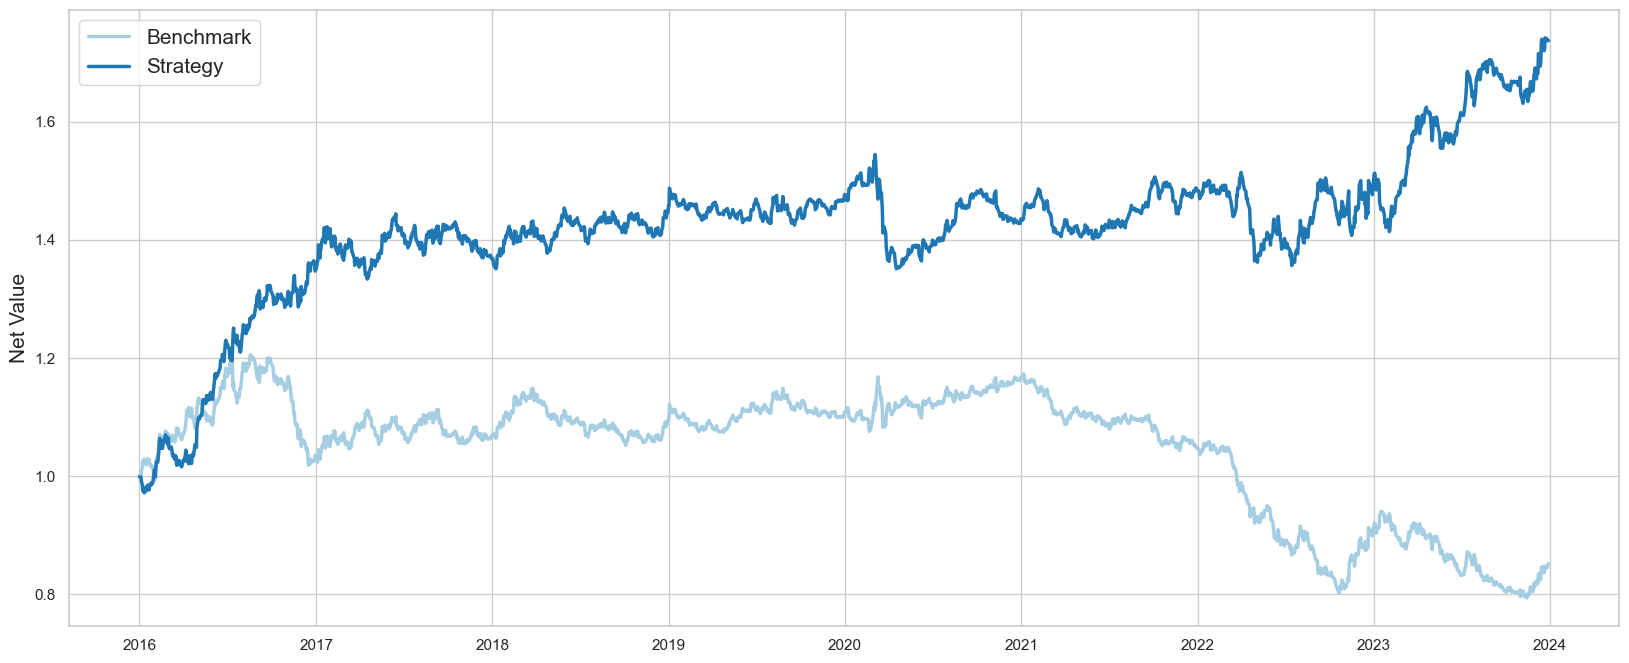

In [19]:
sns.set(style='whitegrid',palette="Paired")
plt.figure(figsize=(20, 8))
plt.plot(data.index,data['NAV'],label='Benchmark',linewidth=2.5)
plt.plot(data.index,data['nav'],label='Strategy',linewidth=2.5)
plt.legend()
plt.ylabel('Net Value',fontsize=15)
plt.legend(loc='upper left',fontsize=15)
plt.show()

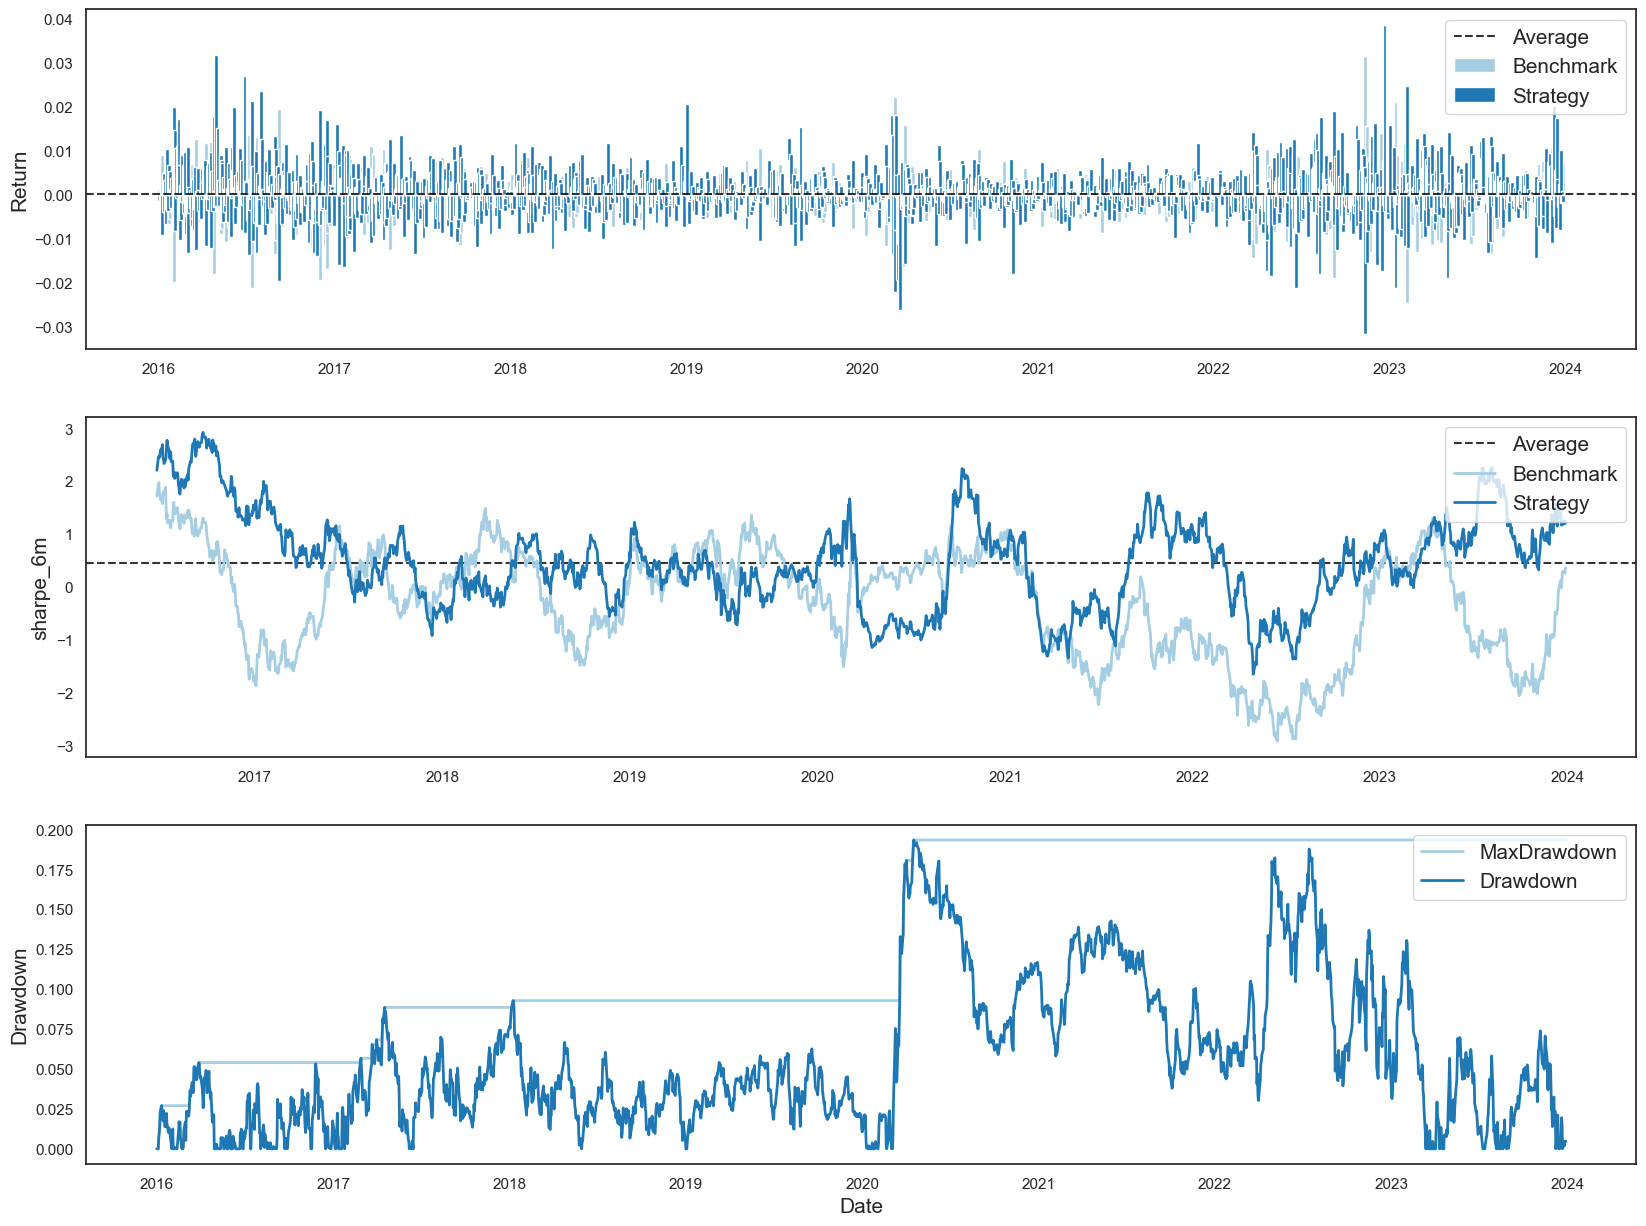

In [20]:
sns.set(style='white',palette="Paired")

data['Mean_6m'] = data['Return'].rolling(window=126).mean()
data['mean_6m'] = data['return'].rolling(window=126).mean()
data['SD_6m'] = data['Return'].rolling(window=126).std()
data['sd_6m'] = data['return'].rolling(window=126).std()
data['Sharpe_6m'] = data['Mean_6m'] / data['SD_6m'] * np.sqrt(126)
data['sharpe_6m'] = data['mean_6m'] / data['sd_6m'] * np.sqrt(126)
nav = data['nav']
peak = nav.iloc[0]
drawdown = [0]
max_drawdown = [0]

for i in range(0, len(nav)):
    if nav.iloc[i] > peak:
        peak = nav.iloc[i]
    drawdown.append(peak - nav.iloc[i])
    max_drawdown.append(np.maximum(max_drawdown[-1], drawdown[-1]))

drawdown = np.array(drawdown)[1:]
max_drawdown = np.array(max_drawdown)[1:]

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.axhline(y=data['return'].mean(), linestyle='--',color='black',alpha=0.8,label='Average')
plt.bar(data.index,data['Return'],label='Benchmark',width=8)
plt.bar(data.index,data['return'],label='Strategy',width=8)
plt.ylabel('Return',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.subplot(3,1,2)
plt.axhline(y=data['sharpe_6m'].mean(), linestyle='--',color='black',alpha=0.8,label='Average')
plt.plot(data.index,data['Sharpe_6m'],label='Benchmark',linewidth=2)
plt.plot(data.index,data['sharpe_6m'],label='Strategy',linewidth=2)
plt.ylabel('sharpe_6m',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.subplot(3,1,3)
plt.plot(nav.index, max_drawdown, label='MaxDrawdown',linewidth=2)
plt.plot(nav.index, drawdown, label='Drawdown',linewidth=2)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Drawdown',fontsize=15)
plt.legend(loc='upper right',fontsize=15)
plt.show()

In [34]:
import yfinance as yf
import statsmodels.api as sm

modifier = 252 # annualize reported stats

data['r-f'] = yf.download('^IRX', start=data.index[0], end=data.index[-1], progress=False)['Close']/(100*modifier)
data['excess_return'] = data['return'] - data['r-f']
data.fillna(method='bfill',inplace=True)
data.head()

,Close,Return,NAV,strategy,return,nav,Mean_6m,mean_6m,SD_6m,sd_6m,Sharpe_6m,sharpe_6m,benchmark,benchmark_return,benchmark_nav,r-f,excess_return,benchmark_excess_return
Date,,,,,,,,,,,,,,,,,,
2016-01-01,0.008313,0.001347,1.001347,-1.0,-0.001347,0.998653,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000006,0.000185,0.000000
2016-01-04,0.008312,-0.000191,1.001155,-1.0,0.000191,0.998844,0.0,0.0,0.0,0.0,0.0,0.0,2012.660034,0.000000,1.000000,0.000006,0.000185,0.000000
2016-01-05,0.008371,0.007065,1.008228,-1.0,-0.007065,0.991788,0.0,0.0,0.0,0.0,0.0,0.0,2016.709961,0.002012,1.002012,0.000008,-0.007073,0.002012
2016-01-06,0.008396,0.003065,1.011318,-1.0,-0.003065,0.988748,0.0,0.0,0.0,0.0,0.0,0.0,1990.260010,-0.013115,0.988870,0.000008,-0.003073,-0.013115
2016-01-07,0.008431,0.004148,1.015513,-1.0,-0.004148,0.984647,0.0,0.0,0.0,0.0,0.0,0.0,1943.089966,-0.023700,0.965434,0.000008,-0.004156,-0.023700


Text(0, 0.5, 'Net Value of Strat vs. SPX')

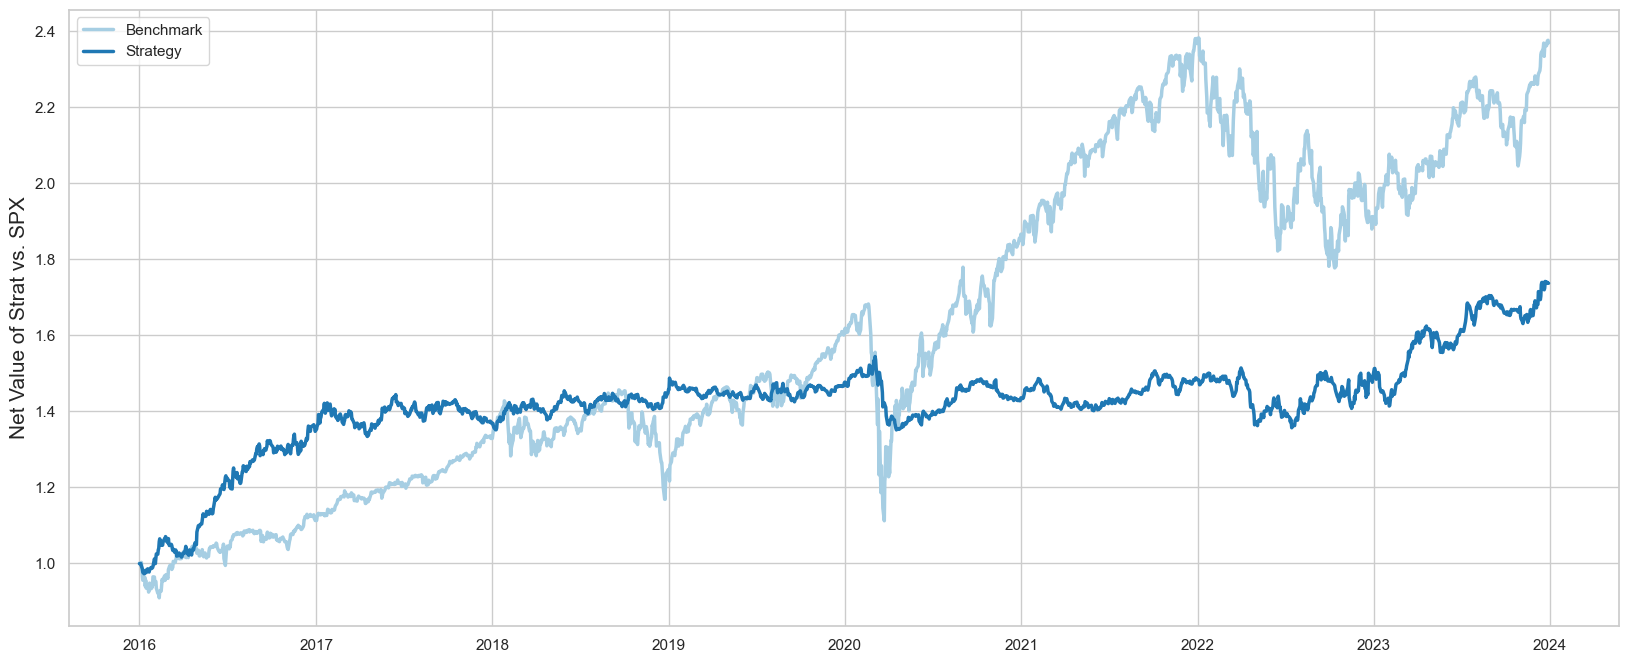

In [35]:
data['benchmark'] = yf.download('^GSPC', start='2016-01-01', end='2023-12-31', progress=False)['Close']
data['benchmark_return'] = data['benchmark'].pct_change()
data['benchmark_excess_return'] = data['benchmark_return'] - data['r-f']
data.fillna(0,inplace=True)
data['benchmark_nav'] = (1+data['benchmark_return']).cumprod()

sns.set(style='whitegrid',palette="Paired")
plt.figure(figsize=(20, 8))
plt.plot(data.index,data['benchmark_nav'],label='Benchmark',linewidth=2.5)
plt.plot(data.index,data['nav'],label='Strategy',linewidth=2.5)
plt.legend()
plt.ylabel('Net Value of Strat vs. SPX',fontsize=15)


In [53]:
def regressOnMarket(series, range=None):
    series = series - data['r-f']
    if range==None:
        X = sm.add_constant(data['benchmark_excess_return'])
    else:
        X = sm.add_constant(data['benchmark_excess_return'].iloc[range[0]:range[1]])
        series = series.iloc[range[0]:range[1]]
    y = series
    model = sm.OLS(y,X)
    results = model.fit()
    return results.params[1], results.params[0]

beta, alpha = regressOnMarket(data['return'])

print(f'Alpha: {alpha*modifier:.6f}%')
print(f'Beta: {beta:.6f}')

Alpha: 0.051773%
Beta: 0.030079


In [45]:
def returnStats(series):
    beta, alpha = regressOnMarket(series)
    return series.mean()*modifier, series.std()*np.sqrt(modifier), (series.mean()-data['r-f'].mean())/(series.std()*np.sqrt(modifier)), beta, alpha*modifier

strat_stats = returnStats(data['return'])
bench_stats = returnStats(data['benchmark_return'])
stats_df = pd.DataFrame([strat_stats,bench_stats],columns=['Return','Volatility','Sharpe Ratio','Beta','Alpha'],index=['Strategy','Benchmark'])
stats_df

,Return,Volatility,Sharpe Ratio,Beta,Alpha
Strategy,0.070660,0.088252,0.002471,0.030079,0.051773
Benchmark,0.121181,0.183009,0.002287,1.000004,-0.000344


Text(0.5, 1.0, 'Rolling Sharpe Ratio of Strat vs. SPX')

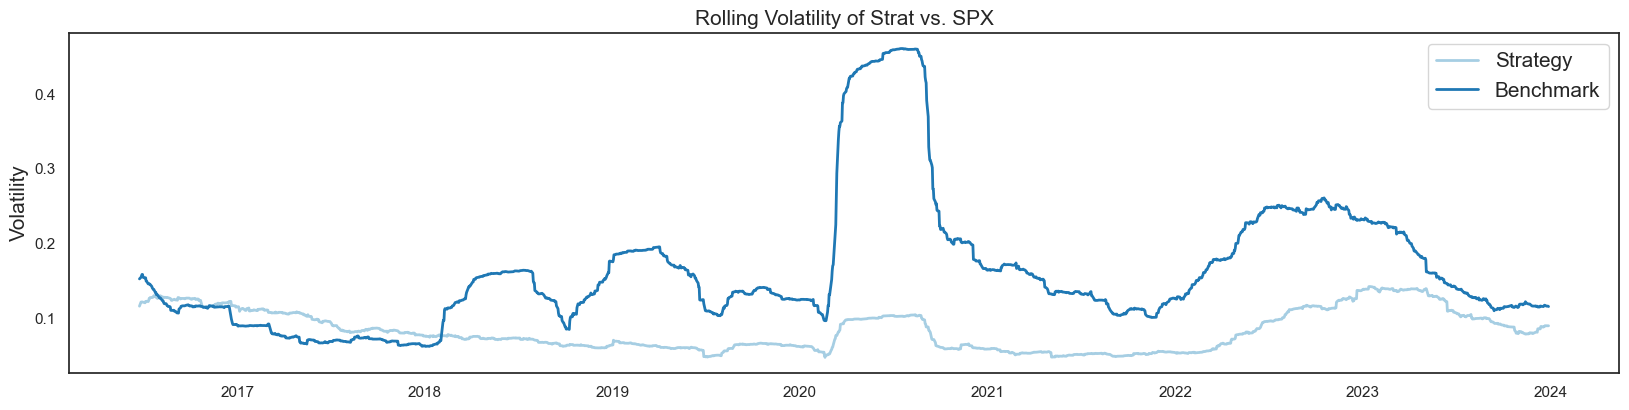

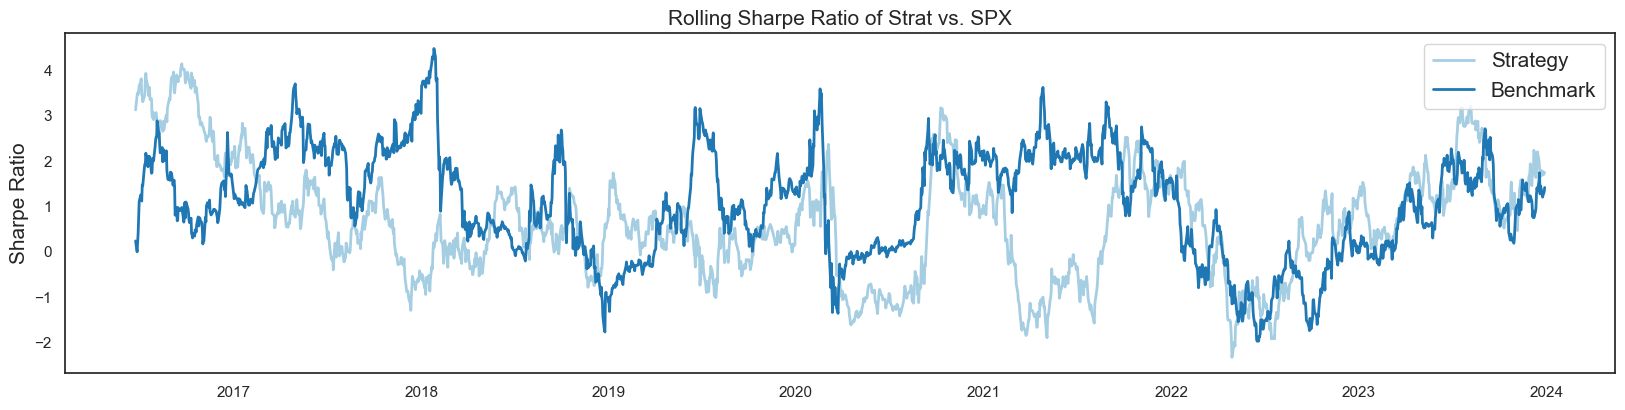

In [49]:
def rolling_volatility(series, window=126):
    return series.rolling(window=window).std()*np.sqrt(modifier)

def rolling_sharpe(series, window=126):
    return series.rolling(window=window).mean()/series.rolling(window=window).std()*np.sqrt(modifier)


sns.set(style='white',palette="Paired")
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(data.index,rolling_volatility(data['return']),label='Strategy',linewidth=2)
plt.plot(data.index,rolling_volatility(data['benchmark_return']),label='Benchmark',linewidth=2)
plt.ylabel('Volatility',fontsize=15)
plt.legend(loc='upper right',fontsize=15)
plt.title('Rolling Volatility of Strat vs. SPX',fontsize=15)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,2)
plt.plot(data.index,rolling_sharpe(data['return']),label='Strategy',linewidth=2)
plt.plot(data.index,rolling_sharpe(data['benchmark_return']),label='Benchmark',linewidth=2)
plt.ylabel('Sharpe Ratio',fontsize=15)
plt.legend(loc='upper right',fontsize=15)
plt.title('Rolling Sharpe Ratio of Strat vs. SPX',fontsize=15)


Text(0.5, 1.0, 'Rolling Beta of Strat vs. SPX')

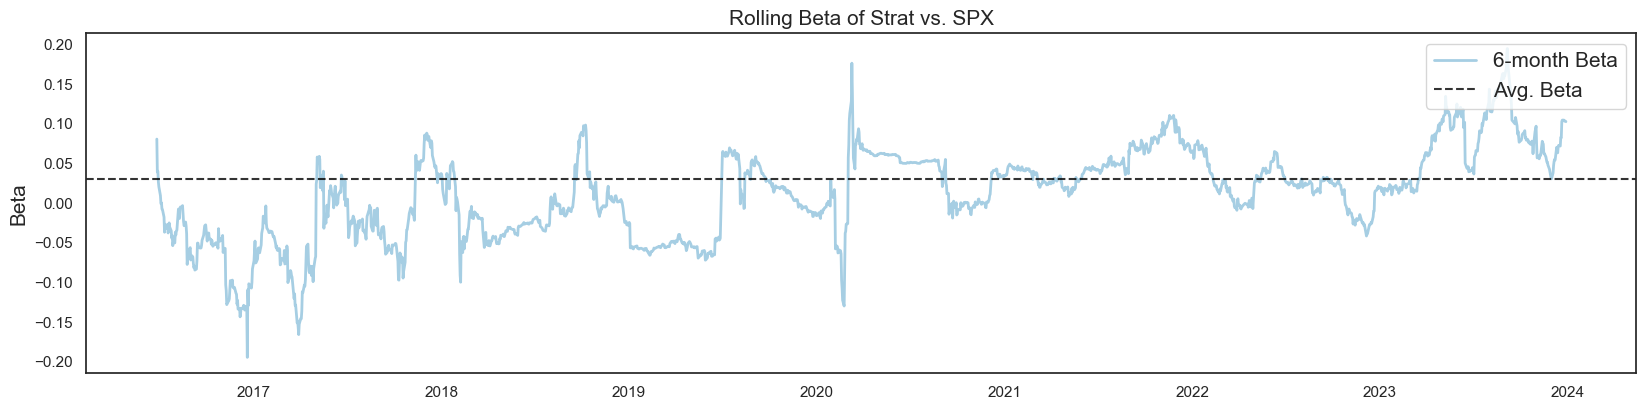

In [58]:
def rollingBeta(series, window=126):
    betas = []
    for i in range(window,len(series)):
        beta, _ = regressOnMarket(series, range=(i-window,i))
        betas.append(beta)
    return pd.Series(betas,index=series.index[window:])



sns.set(style='white',palette="Paired")
plt.figure(figsize=(20, 15))
plt.subplot(3,1,3)
plt.plot(data.index[126:],rollingBeta(data['return']),label='6-month Beta',linewidth=2)
plt.axhline(y=beta, linestyle='--',color='black',alpha=0.8,label='Avg. Beta')
plt.ylabel('Beta',fontsize=15)
plt.legend(loc='upper right',fontsize=15)
plt.title('Rolling Beta of Strat vs. SPX',fontsize=15)